In [1]:
import sys, os
import importlib
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PARENT_DIR)
conf = importlib.import_module('confs.pendulum_conf')
env = getattr(conf, 'PendulumEnv')(conf)


from neural_network import ActorCriticNet
from rl_trainer import RLTrainer
from opt.traj_opt import TrajOpt

ac_net = ActorCriticNet(env, conf)
actor = ac_net.create_actor()
critic = ac_net.create_critic_sine()
TO = TrajOpt(env, conf)

# Load the weights
actor_path = '/home/seyoungree/Documents/GATO-RL/pendulum/2025-07-24_16-37/actor_final.pth'
critic_path = '/home/seyoungree/Documents/GATO-RL/pendulum/2025-07-24_16-37/critic_final.pth'
actor.load_state_dict(torch.load(actor_path, map_location='cpu'))
critic.load_state_dict(torch.load(critic_path, map_location='cpu'))
actor.eval()
critic.eval()

Sequential(
  (0): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (1): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (2): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (3): Siren(
    (activation): Sine()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [3]:
%matplotlib inline

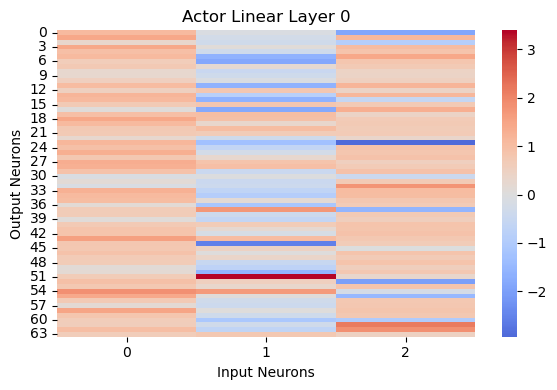

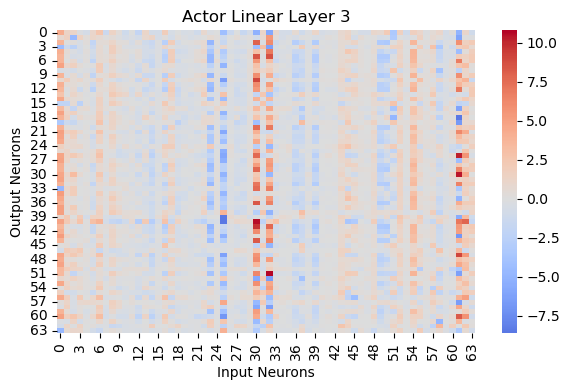

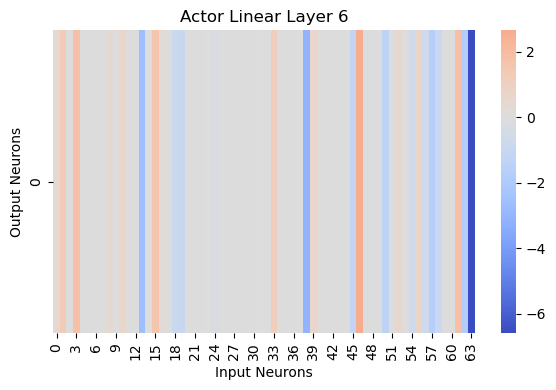

In [4]:
def visualize_weights(weights, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(weights, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    plt.tight_layout()
    plt.show()

def visualize_model_weights(model, name="Model"):
    for i, layer in enumerate(model):
        # Standard linear layer
        if isinstance(layer, nn.Linear):
            w = layer.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Linear Layer {i}")
        
        elif hasattr(layer, "linear") and isinstance(layer.linear, nn.Linear):
            w = layer.linear.weight.detach().cpu().numpy()
            visualize_weights(w, f"{name} Siren Layer {i}")
# Visualize
visualize_model_weights(actor, "Actor")

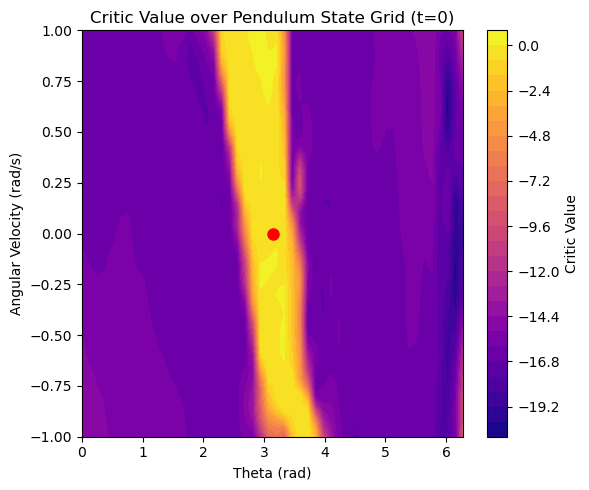

In [5]:
theta_min, w_min = conf.X_INIT_MIN[:2]
theta_max, w_max = conf.X_INIT_MAX[:2]

# Grid over theta and angular velocity
theta = np.linspace(theta_min, theta_max, 50)
w = np.linspace(w_min, w_max, 50)
Theta, W = np.meshgrid(theta, w)
T = np.zeros_like(Theta)  # time fixed at t=0

# Stack into (N, 3) state vectors
states = np.stack([Theta.ravel(), W.ravel(), T.ravel()], axis=1)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Evaluate critic
with torch.no_grad():
    values = ac_net.eval(critic, states_tensor).cpu().numpy().reshape(Theta.shape)

# Plotting
plt.figure(figsize=(6, 5))
contour = plt.contourf(Theta, W, values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Critic Value')

theta_goal, w_goal = env.goal_state[:2]
plt.plot(theta_goal, w_goal, 'ro', markersize=8, label='Goal State')


plt.xlabel('Theta (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Critic Value over Pendulum State Grid (t=0)')
plt.tight_layout()
plt.show()

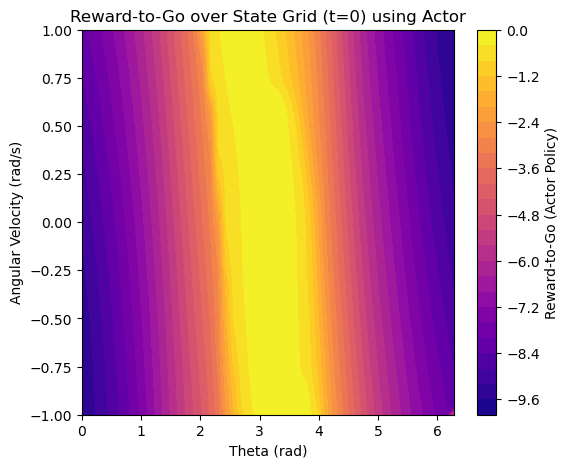

In [6]:
# Compute actual reward-to-go values using compute_partial_rtg for each grid state, with actor actions
rtg_values = np.zeros_like(Theta)
trainer = RLTrainer(env, None, conf, N_try=0)

for idx, (p, v) in enumerate(zip(Theta.ravel(), W.ravel())):
    init_state = np.array([p, v, 0.0])
    states = np.zeros((conf.NSTEPS + 1, conf.nx + 1))
    states[0] = init_state
    actions = np.zeros((conf.NSTEPS, conf.nu))
    for t in range(conf.NSTEPS):
        # Prepare state for actor (batch of 1)
        state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
        with torch.no_grad():
            action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
        actions[t] = action
        # Simulate next state
        states[t + 1] = env.simulate(states[t], actions[t])
        # states[t + 1, :2] = 0
    _, rtg, _, _, _ = trainer.compute_partial_rtg(actions, states)
    rtg_values.ravel()[idx] = rtg[0]

# Plot the RTG values
plt.figure(figsize=(6,5))
contour = plt.contourf(Theta, W, rtg_values, levels=30, cmap='plasma')
plt.colorbar(contour, label='Reward-to-Go (Actor Policy)')
plt.xlabel('Theta (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Reward-to-Go over State Grid (t=0) using Actor')
plt.show()

   t |        x |        v |        u
----------------------------------------
   0 |    0.000 |    0.000 |   -5.000
   1 |    0.000 |   -0.050 |   -5.000
   2 |   -0.000 |   -0.100 |   -5.000
   3 |   -0.001 |   -0.150 |   -5.000
   4 |   -0.003 |   -0.200 |   -5.000
   5 |   -0.005 |   -0.250 |   -5.000
   6 |   -0.007 |   -0.299 |   -5.000
   7 |   -0.010 |   -0.348 |   -4.999
   8 |   -0.014 |   -0.397 |   -4.999
   9 |   -0.018 |   -0.446 |   -4.999
  10 |   -0.022 |   -0.494 |   -4.999
  11 |   -0.027 |   -0.542 |   -4.999
  12 |   -0.033 |   -0.589 |   -5.000
  13 |   -0.039 |   -0.636 |   -5.000
  14 |   -0.045 |   -0.682 |   -5.000
  15 |   -0.052 |   -0.728 |   -5.000
  16 |   -0.059 |   -0.773 |   -5.000
  17 |   -0.067 |   -0.817 |   -5.000
  18 |   -0.075 |   -0.860 |   -5.000
  19 |   -0.084 |   -0.903 |   -5.000
  20 |   -0.093 |   -0.945 |   -5.000
  21 |   -0.102 |   -0.986 |   -5.000
  22 |   -0.112 |   -1.026 |   -5.000
  23 |   -0.122 |   -1.065 |   -5.000
  24 |   

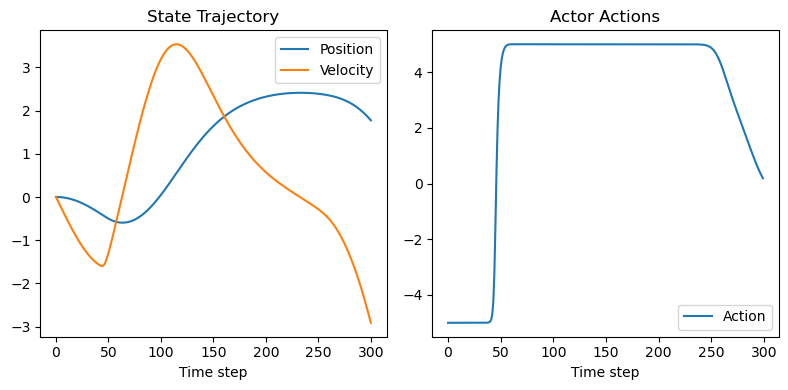

In [8]:
# Test the actor with a single trajectory rollout from an initial state
T = 0.0
steps = conf.NSTEPS - int(T / conf.dt)
init_state = np.array([0, 0, T])  # Example initial state: [position, velocity, time]
states = np.zeros((steps + 1, conf.nx + 1))
states[0] = init_state
actions = np.zeros((steps, conf.nu))

print(f"{'t':>4} | {'x':>8} | {'v':>8} | {'u':>8}")
print("-" * 40)

for t in range(steps):
    state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
    with torch.no_grad():
        action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
    print(f"{t:4d} | {states[t, 0]:8.3f} | {states[t, 1]:8.3f} | {action:8.3f}")
    actions[t] = action
    states[t + 1] = env.simulate(states[t], actions[t])

# Plot the trajectory
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[:,0], label='Position')
plt.plot(states[:,1], label='Velocity')
plt.xlabel('Time step')
plt.title('State Trajectory')
plt.legend()

plt.subplot(1,2,2)
plt.plot(actions, label='Action')
plt.xlabel('Time step')
plt.title('Actor Actions')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import matplotlib.colors as mcolors
theta_vals = np.linspace(conf.X_INIT_MIN[0], conf.X_INIT_MAX[0], 20)
omega_vals = np.linspace(conf.X_INIT_MIN[1], conf.X_INIT_MAX[1], 20)
T = 1.5  # starting time

nx, nu = conf.nx, conf.nu
trainer = RLTrainer(env, ac_net, conf, 0)

cost_actor = np.zeros((len(omega_vals), len(theta_vals)))
cost_zero = np.zeros_like(cost_actor)
iters_actor = np.zeros_like(cost_actor)
iters_zero = np.zeros_like(cost_actor)

for i, w in enumerate(omega_vals):
    for j, th in enumerate(theta_vals):
        steps = conf.NSTEPS - int(T / conf.dt)
        init_state = np.array([th, w, T])

        # --- Actor rollout ---
        states = np.zeros((steps + 1, nx + 1))
        actions = np.zeros((steps, nu))
        states[0] = init_state

        for t in range(steps):
            state_tensor = torch.tensor(states[t][None], dtype=torch.float32)
            with torch.no_grad():
                action = ac_net.eval(actor, state_tensor, is_actor=True).cpu().numpy().squeeze()
            actions[t] = action
            states[t + 1] = env.simulate(states[t], actions[t])

        # === TO with actor warmstart ===
        try:
            opt_states, opt_actions, iters_a, _ = TO.solve_pend_constrained_SQP(
                states, actions, display_flag=False
            )
            N = opt_states.shape[0]
            num_vars = (N - 1) * (nx + nu) + nx
            x_guess = np.zeros((num_vars, 1))
            for k in range(N - 1):
                idx = k * (nx + nu)
                x_guess[idx:idx + nx, 0] = opt_states[k, :2]
                x_guess[idx + nx, 0] = opt_actions[k, 0]
            x_guess[-nx:, 0] = opt_states[-1, :2]
            cost_actor[i, j] = env.running_cost(x_guess)
            iters_actor[i, j] = iters_a
        except Exception as e:
            cost_actor[i, j] = np.nan
            iters_actor[i, j] = np.nan
            print(f"Actor TO failed at (θ={th:.2f}, ω={w:.2f}): {e}")

        # === TO with zero warmstart ===
        try:
            zero_states = np.zeros((steps + 1, nx + 1))
            zero_states[:, 2] = np.linspace(T, T + conf.dt * steps, steps + 1)
            zero_states[0, :2] = [th, w]
            zero_actions = np.zeros((steps, nu))

            opt_states, opt_actions, iters_z, _ = TO.solve_pend_constrained_SQP(
                zero_states, zero_actions, display_flag=False
            )
            N = opt_states.shape[0]
            x_guess = np.zeros((num_vars, 1))
            for k in range(N - 1):
                idx = k * (nx + nu)
                x_guess[idx:idx + nx, 0] = opt_states[k, :2]
                x_guess[idx + nx, 0] = opt_actions[k, 0]
            x_guess[-nx:, 0] = opt_states[-1, :2]
            cost_zero[i, j] = env.running_cost(x_guess)
            iters_zero[i, j] = iters_z
        except Exception as e:
            cost_zero[i, j] = np.nan
            iters_zero[i, j] = np.nan
            print(f"Zero TO failed at (θ={th:.2f}, ω={w:.2f}): {e}")

# Compute differences
cost_diff = cost_actor - cost_zero  # positive = actor worse
iters_diff = iters_zero - iters_actor  # positive = actor uses fewer iterations

/tmp/ipykernel_395003/3640828032.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_actor[i, j] = env.running_cost(x_guess)
/tmp/ipykernel_395003/3640828032.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_zero[i, j] = env.running_cost(x_guess)


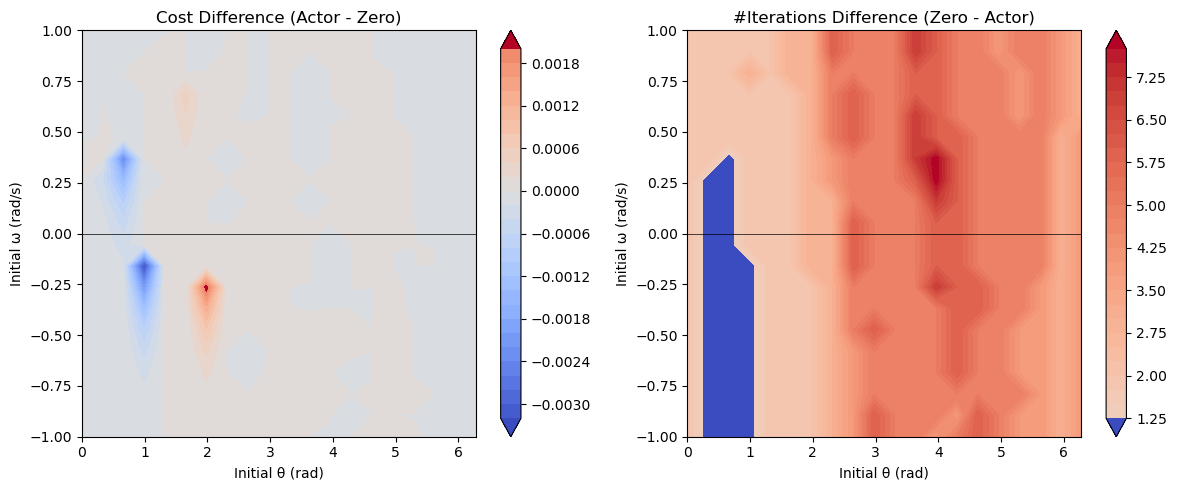

In [10]:
# --- Plot side-by-side ---
Theta, Omega = np.meshgrid(theta_vals, omega_vals, indexing='xy')

vmax_cost = np.nanmax(np.abs(cost_diff))
norm_cost = mcolors.TwoSlopeNorm(vmin=-vmax_cost, vcenter=0.0, vmax=vmax_cost)
vmax_iters = np.nanmax(np.abs(iters_diff))
norm_iters = mcolors.TwoSlopeNorm(vmin=-vmax_iters, vcenter=0.0, vmax=vmax_iters)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_xlim(theta_vals[0], theta_vals[-1])
axs[0].set_ylim(omega_vals[0], omega_vals[-1])
axs[1].set_xlim(theta_vals[0], theta_vals[-1])
axs[1].set_ylim(omega_vals[0], omega_vals[-1])
c1 = axs[0].contourf(Theta, Omega, cost_diff, levels=30, cmap='coolwarm', norm=norm_cost, extend='both')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('Cost Difference (Actor - Zero)')
axs[0].set_xlabel('Initial θ (rad)')
axs[0].set_ylabel('Initial ω (rad/s)')
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].axvline(0, color='black', linewidth=0.5)

c2 = axs[1].contourf(Theta, Omega, iters_diff, levels=30, cmap='coolwarm', norm=norm_iters, extend='both')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('#Iterations Difference (Zero - Actor)')
axs[1].set_xlabel('Initial θ (rad)')
axs[1].set_ylabel('Initial ω (rad/s)')
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()


In [11]:
iters_diff

array([[2., 1., 1., 1., 2., 2., 2., 3., 4., 6., 5., 5., 4., 5., 6., 5., 4., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 4., 6., 5., 5., 5., 4., 6., 5., 4., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 4., 5., 5., 5., 5., 5., 5., 5., 5., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 4., 5., 5., 5., 5., 6., 5., 5., 4., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 4., 5., 5., 5., 5., 6., 5., 5., 4., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 5., 6., 5., 5., 5., 6., 5., 5., 4., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 5., 5., 5., 5., 5., 6., 6., 5., 5., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 2., 3., 5., 5., 5., 5., 7., 6., 6., 5., 5., 4., 3., 4.],
       [2., 1., 1., 1., 2., 2., 3., 3., 6., 5., 5., 5., 6., 6., 5., 5., 5., 5., 3., 4.],
       [2., 1., 1., 2., 2., 2., 3., 3., 6., 5., 5., 5., 6., 6., 5., 5., 5., 5., 3., 4.],
       [2., 1., 1., 2., 2., 2., 3., 3., 6., 5., 5., 5., 6., 6., 5., 5., 5., 5., 3., 4.],
       [2., 1., 1., 2